In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from astroML import stats as astroMLstats
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV


plt.rcParams['figure.figsize'] = [5, 5]
%config InlineBackend.figure_format='retina'

### Freedman-Diaconis

Freedman-Diaconis bin-size =  0.016258331390641725


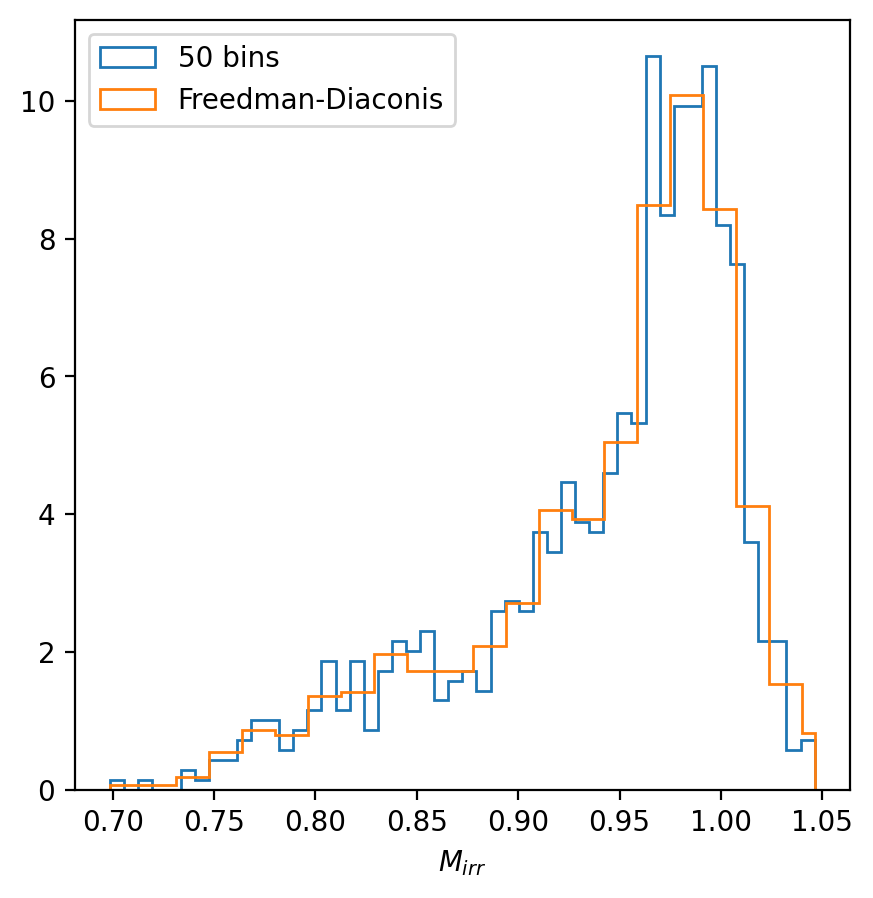

In [2]:
np.random.seed(0)

N=1000
mu = 1
chi = stats.uniform(0, 1).rvs(N)
f = lambda x : ((1+(1-x**2)**0.5)/2)**0.5

def Mirr_func(sigma):
    np.random.seed(0)
    M = stats.norm(mu, sigma).rvs(N)
    return M*f(chi)

Mirr = Mirr_func(0.02)
plt.hist(Mirr, bins=50, density=True, histtype='step', label='50 bins')

delta_FD = 2.7*(astroMLstats.sigmaG(Mirr))/(N**(1/3))
print('Freedman-Diaconis bin-size = ', delta_FD)
bins = np.append(np.arange(Mirr.min(), Mirr.max(), step=delta_FD), Mirr.max())  
plt.hist(Mirr, bins=bins, density=True, histtype='step', label='Freedman-Diaconis')
plt.xlabel('$M_{irr}$')    
plt.legend()
plt.show()

### Kernel Density Estimation

In [3]:
from sklearn.neighbors import KernelDensity
from astropy.visualization.hist import hist as fancyhist

def kde_sklearn(data, bandwidth = 1.00, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    xgrid = np.linspace(np.min(data), np.max(data), 1000)
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis])

    return np.exp(log_pdf)

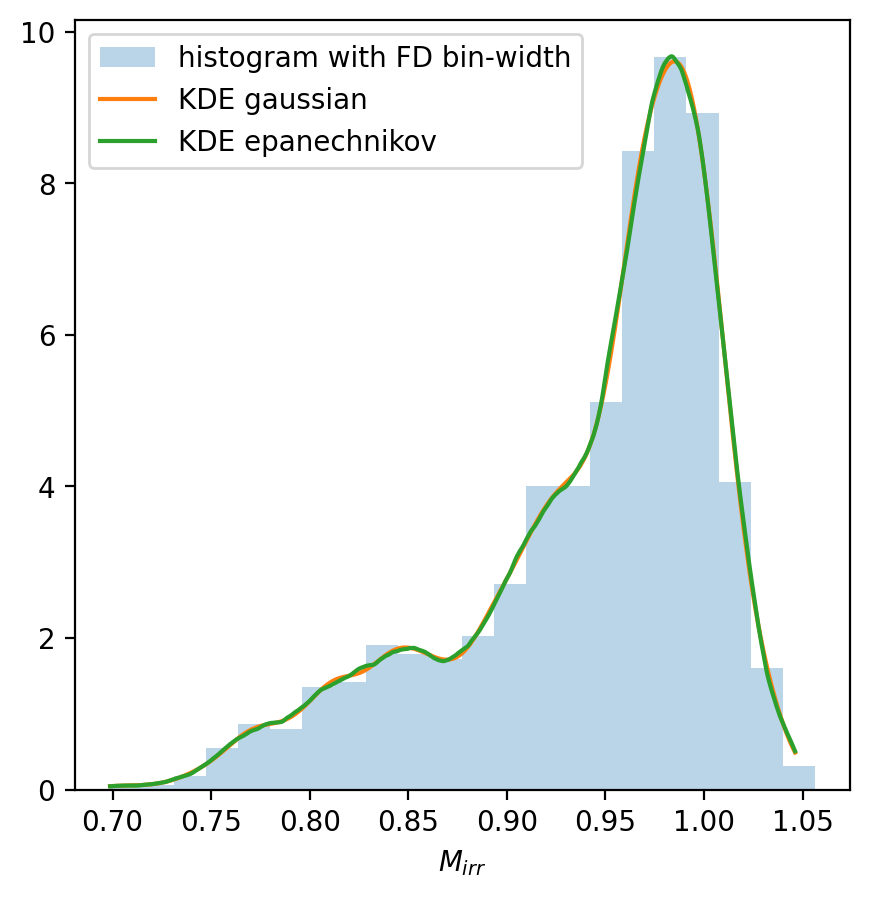

In [4]:
Mirr = Mirr_func(0.02)
_ = fancyhist(Mirr, bins='freedman', alpha=0.3,density=True, label='histogram with FD bin-width')
bwrange = np.linspace(0.002,0.025, 20)
K = 10 
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bwrange}, cv= K)
grid.fit(Mirr[:, None])
bw_opt_G = grid.best_params_['bandwidth']
PDFgauss = kde_sklearn(Mirr,bandwidth=bw_opt_G, kernel='gaussian')

bwrange = np.linspace(0.02,0.035, 20)
grid = GridSearchCV(KernelDensity(kernel='epanechnikov'), {'bandwidth': bwrange}, cv= K)
grid.fit(Mirr[:, None])
bw_opt_E = grid.best_params_['bandwidth']
PDFep = kde_sklearn(Mirr,bandwidth=bw_opt_E, kernel='epanechnikov')

xgrid = np.linspace(np.min(Mirr), np.max(Mirr), 1000)
plt.plot(xgrid, PDFgauss, label='KDE gaussian')
plt.plot(xgrid, PDFep, label='KDE epanechnikov')
plt.xlabel('$M_{irr}$')    
plt.legend()
plt.show()

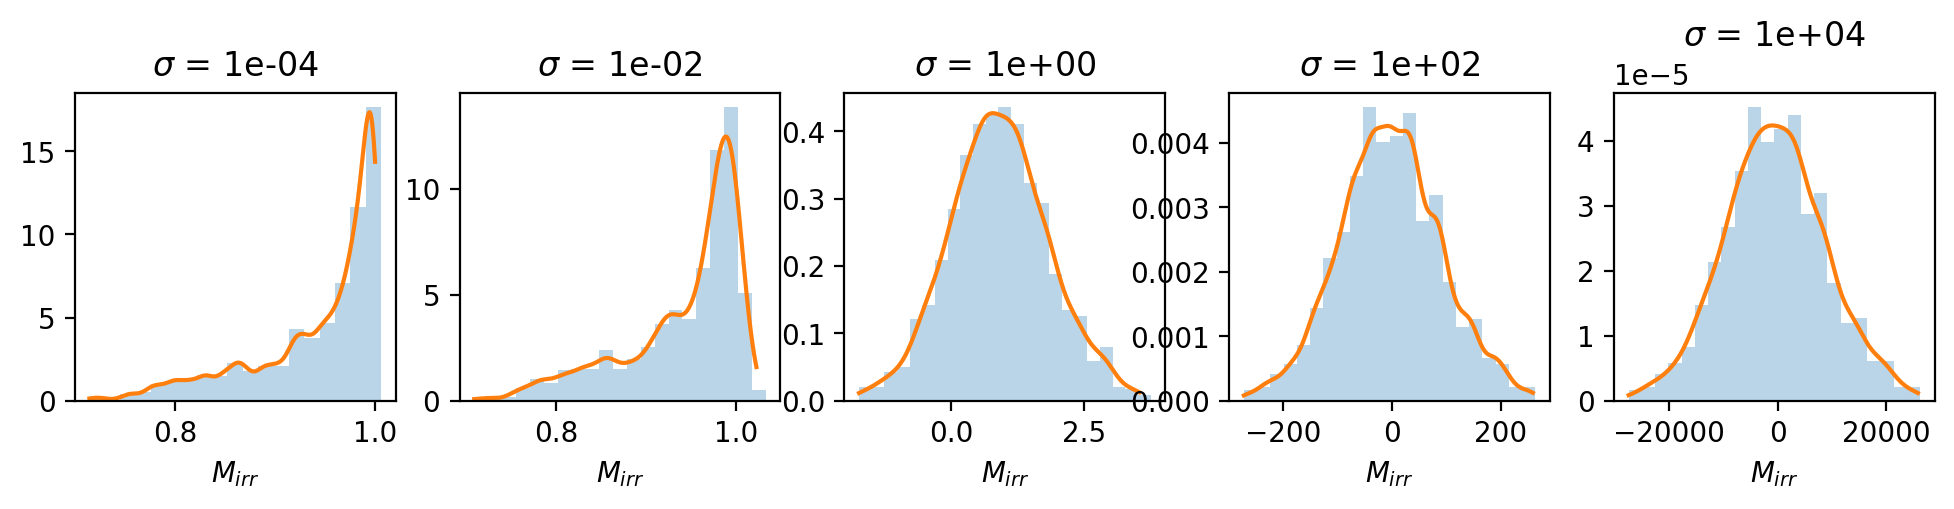

In [5]:
sigma = np.logspace(-4,4,5)
width = [0.007,0.01,0.2,15,2000]
fig,axs=plt.subplots(1,5,figsize=(12,2))

for s,w,ax in zip(sigma,width,axs):
    Mirr = Mirr_func(s)
    _ = fancyhist(Mirr,bins='freedman', ax=ax, alpha=0.3, density=True)
    PDFgauss = kde_sklearn(Mirr,bandwidth=w, kernel='gaussian')
    xgrid = np.linspace(np.min(Mirr), np.max(Mirr), 1000)
    ax.plot(xgrid, PDFgauss)
    ax.set_xlabel('$M_{irr}$')
    ax.set_title(r'$\sigma$ = %.e'%s)
plt.show()

### Varying sigma

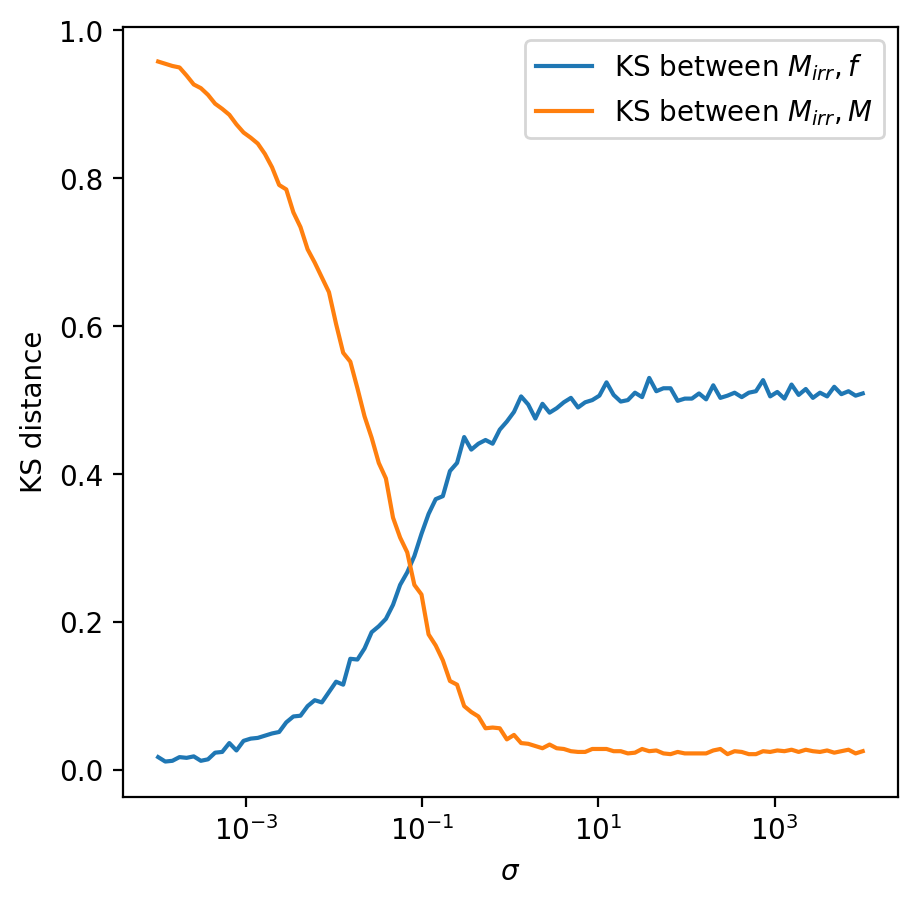

In [6]:
KS_f = np.array([])
KS_M = np.array([])
sigma = np.logspace(-4,4,100)

for s in zip(sigma):
    M = stats.norm(mu, s).rvs(N)
    KS_f = np.append(KS_f, scipy.stats.ks_2samp(M*f(chi),f(chi))[0])
    KS_M = np.append(KS_M, scipy.stats.ks_2samp(M*f(chi),M)[0])
plt.plot(sigma, KS_f, label="KS between $M_{irr}, f$")
plt.plot(sigma, KS_M, label="KS between $M_{irr}, M$")
plt.xlabel("$\sigma$")
plt.ylabel('KS distance')
plt.legend()
plt.xscale('log')

This plot shows that $M_{irr}$ is distributed like $f$ for ${\sigma}$ much smaller than $\mu$ and $M_{irr}$ is distributed like $M$ for $\sigma$ much greater than $\mu$.

### Mathematical pdf
$ \pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}} $ is the pdf of $f$. Its domain is $[ \frac{1}{\sqrt{2}},1 ]$


Then we can use the theorem for the distribution of the product of two random variables:

$ p(M_{\rm irr}) = \int_{-\infty}^{+\infty} {\rm pdf}_f(f) {\rm pdf}_M(\frac{M_{\rm irr}}{f}) \frac{1}{|f|} \,\, {\rm d}f $

which becomes

$ p(M_{\rm irr})  = \frac{2}{\sqrt{2\pi\sigma^2}} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}\,\, {\rm d}f $

It can be integrated numerically

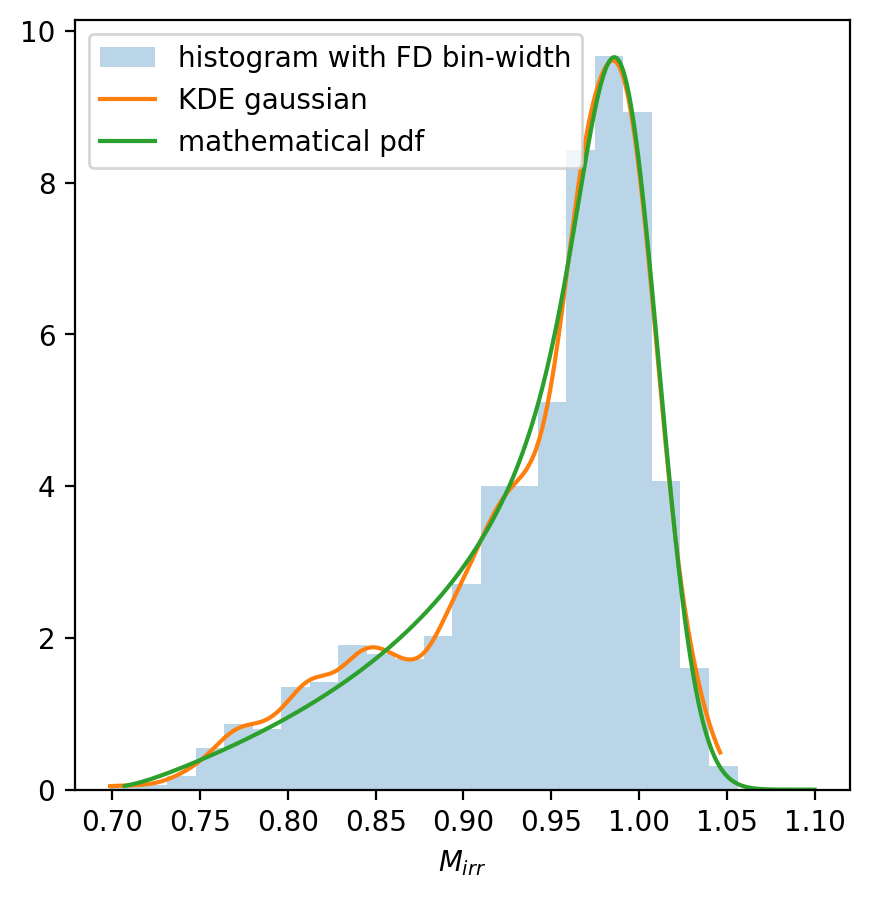

In [7]:
def pi(f):
    return 2*(2*f**2-1)/(1 - f**2)**0.5
sigma = 0.02
Mirr = Mirr_func(sigma)
_ = fancyhist(Mirr, bins='freedman', alpha=0.3, density=True, label='histogram with FD bin-width')
PDFgauss = kde_sklearn(Mirr, bandwidth=bw_opt_G, kernel='gaussian')
xgrid = np.linspace(np.min(Mirr), np.max(Mirr), 1000)
plt.plot(xgrid, PDFgauss, label='KDE gaussian')

def integrand(f,x):
    return ((2/np.pi)**0.5/sigma)*np.exp(-(x/f -1)**2/(2*sigma**2))*(2*f**2-1)/(1-f**2)**0.5/f

xgrid = np.linspace(1/np.sqrt(2),1.1,N)
Mirr = [scipy.integrate.quad(lambda f: integrand(f,x), 1/2**0.5,1)[0] for x in xgrid]

plt.plot(xgrid,Mirr, label='mathematical pdf')
plt.xlabel('$M_{\\rm irr}$')
plt.xlabel('$M_{irr}$')    
plt.legend()
plt.show()